In [83]:
import tensorflow as tf

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# SIFT

Definimos funciones que nos seran utiles posteriormente

In [84]:
def get_n_similar(n):
  sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=True)[:n]
  sorted_indexes = [int(float(tupl[0])) for tupl in sorted_counts]
  return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        idx = sorted_indexes[i]
        im = cv2.cvtColor(cv2.imread(f'n04487081_{str(idx)}.JPEG'), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')

    plt.show()

Para este proyecto vamos a usar un subconjunto de imagenes de imagenet

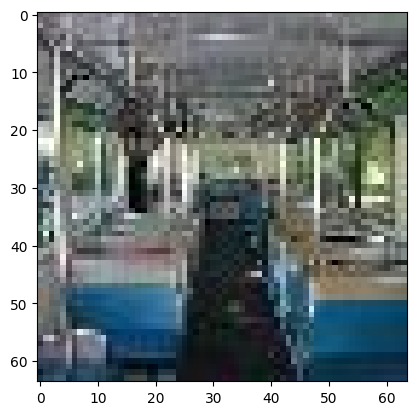

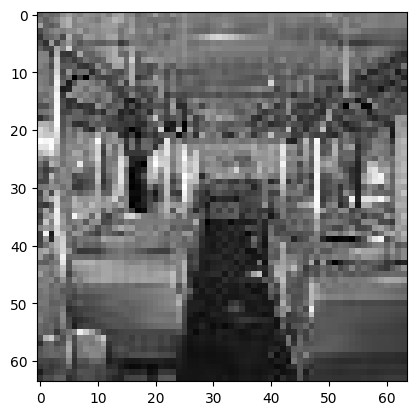

In [85]:
im1 = cv2.imread('n04487081_0.JPEG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
gray_im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im1, cmap='gray')
plt.show()

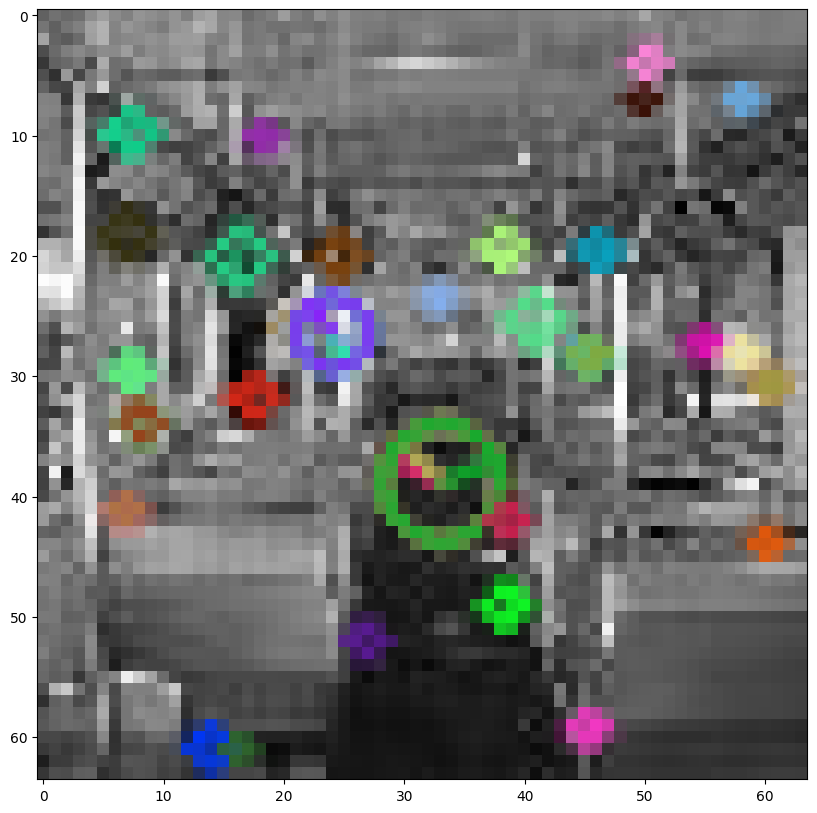

In [86]:
sift = cv2.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(gray_im1, mask=None)
im1_sift = cv2.drawKeypoints(gray_im1, keypoints_1, im1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(10,10))
plt.imshow(im1_sift)
plt.show()

creamos una matriz numpy donde almacenaremos todos los descriptores con la etiqueta de la imagen a la q pertenecen

In [87]:
sift = cv2.SIFT_create()
descriptors = np.empty((0,129))
for i in range(0, 100):
  gray_im = cv2.cvtColor(cv2.imread(f'n04487081_{i}.JPEG'), cv2.COLOR_BGR2GRAY)
  _ , descriptor = sift.detectAndCompute(gray_im, mask=None)

  descriptors_arr = np.array(descriptor)
  descriptors_arr = np.insert(descriptors_arr, 0, str(i), axis=1)
  descriptors =  np.vstack([descriptors, descriptors_arr])



In [88]:
descriptors.shape

(3821, 129)

Entrenamos knn

In [89]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 1:]
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean')

La estrategia para determinar las imagenes mas similares sera la siguiente:

1.- Obtenemos para cada descriptor de la imagen nueva sus 5 descriptores mas cercanos.

2.- Obtenemos los ID de las imagenes a las que pertenecen dichos descriptores.

3.- Almacenamos en un diccionario el numero de veces que aparece un descriptor de cada imagen.

4.- Recuperamos las n imagenes con mayor numero de descriptores coincidentes con los de la imagen nueva.

In [90]:
counts = {}
new_img = cv2.cvtColor(cv2.imread('n04487081_3.JPEG'), cv2.COLOR_BGR2GRAY)
_ , descriptor = sift.detectAndCompute(new_img, mask=None)
descriptors_arr = np.array(descriptor)
for descriptor_i in descriptor:
  descriptor_i = descriptor_i.reshape(1, -1)
  distance, indice = knn.kneighbors(descriptor_i, n_neighbors=5)
  for idx in indice[0]:
    id = str(descriptors[idx,0])
    if id in counts:
      counts[id] += 1
    else:
      counts[id] = 1

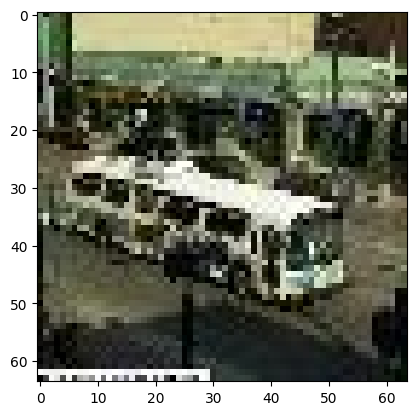

Solo hay 5 imágenes en la lista. Mostrando todas.


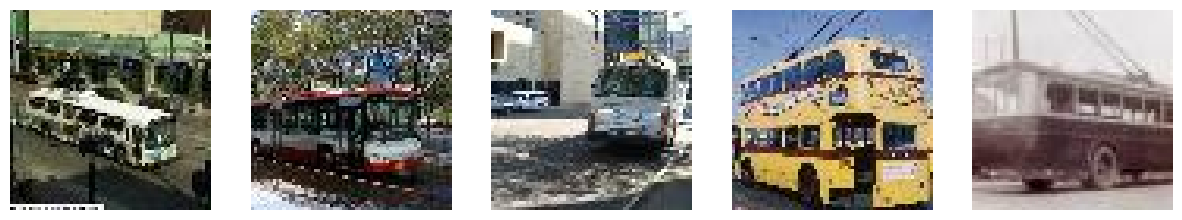

In [97]:
im1 = cv2.imread('n04487081_3.JPEG')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
plt.imshow(im1)
plt.show()
sorted_indexes = get_n_similar(5)
display_n_similar(sorted_indexes, 8)

# CNN

In [92]:
from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)


In [93]:
caracteristics = np.empty((0,25089))
for i in range(0, 100):
  im = cv2.cvtColor(cv2.imread(f'n04487081_{i}.JPEG'), cv2.COLOR_BGR2RGB)
  # Redimensionar la imagen al tamaño requerido por el modelo
  target_size = (224, 224)
  im = cv2.resize(im, target_size)
  # Agregar una dimensión
  im = np.expand_dims(im, axis=0)
  # Normalizar la imagen
  im = preprocess_input(im)

  # Extraer las características de la imagen
  caracteristics_img = model.predict(im, verbose=0)
  caracteristics_flat = caracteristics_img.reshape(1, -1)
  caracteristics_flat = np.insert(caracteristics_flat, 0, str(i), axis=1)
  caracteristics =  np.vstack([caracteristics, caracteristics_flat])


In [94]:
caracteristics.shape

(100, 25089)

In [95]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

caracteristics_train = caracteristics[:, 1:]
knn.fit(caracteristics_train)

NearestNeighbors(metric='euclidean')

1/1 [==============================] - 1s 536ms/step
Solo hay 5 imágenes en la lista. Mostrando todas.


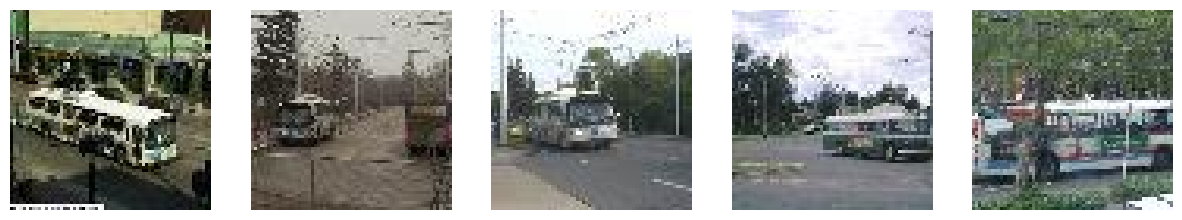

In [96]:
im = cv2.cvtColor(cv2.imread('n04487081_3.JPEG'), cv2.COLOR_BGR2RGB)
# Redimensionar la imagen al tamaño requerido por el modelo
target_size = (224, 224)
im = cv2.resize(im, target_size)
# Agregar una dimensión
im = np.expand_dims(im, axis=0)
# Normalizar la imagen
im = preprocess_input(im)

# Extraer las características de la imagen
caracteristics_img = model.predict(im)
caracteristics_flat = caracteristics_img.reshape(1, -1)
distance, indice = knn.kneighbors(caracteristics_flat, n_neighbors=5)



display_n_similar(indice[0], 8)